In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import random
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import cvxpy as cp


c:\Users\Swarnarup\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Importing and Plotting Dataset

In [3]:
df = pd.read_csv("Social_Network_Ads.csv")

In [4]:
df["Gender"] = [1 if i=="Male" else 2 for i in df["Gender"]]
cols = df.columns
df

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,1,19.0,19000.0,0
1,15810944,1,35.0,20000.0,0
2,15668575,2,26.0,43000.0,0
3,15603246,2,27.0,57000.0,0
4,15804002,1,19.0,76000.0,0
...,...,...,...,...,...
395,15691863,2,46.0,41000.0,1
396,15706071,1,51.0,23000.0,1
397,15654296,2,50.0,20000.0,1
398,15755018,1,36.0,33000.0,0


C:\Users\Swarnarup\AppData\Local\Temp\ipykernel_23728\1091802327.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


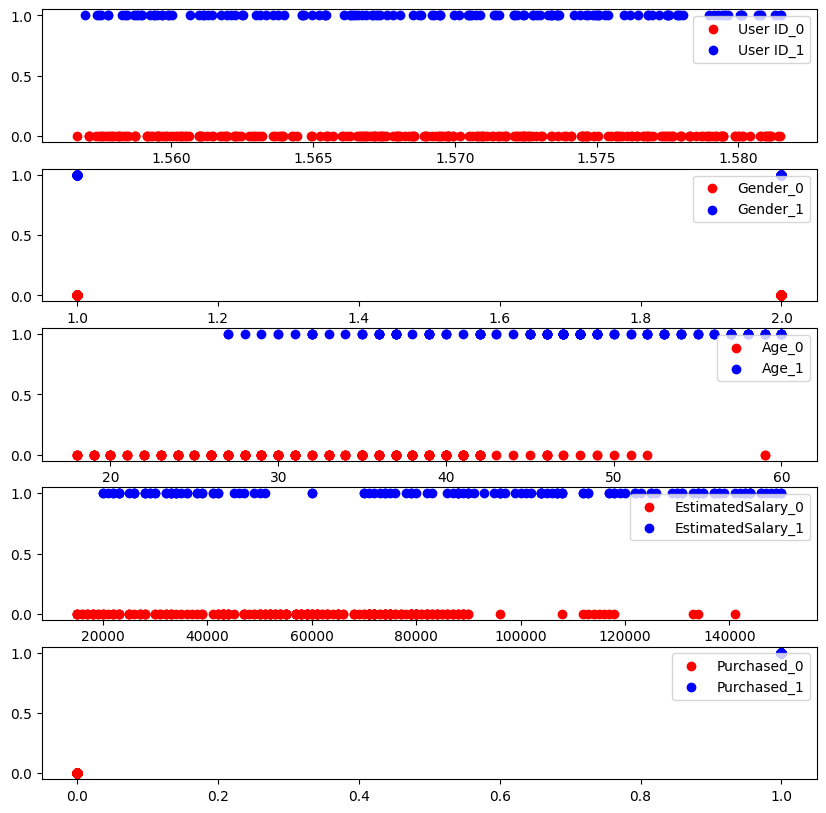

In [5]:
# df[df["Purchased"]==0].hist(figsize=(15,10))
# df[df["Purchased"]==1].hist(figsize=(15,10))

fig, l = plt.subplots(len(cols),1,figsize=(10,10))

for i in range(len(cols)):

    l[i].scatter(df[df["Purchased"]==0][cols[i]], [0 for ii in df[df["Purchased"]==0][cols[i]]], color='r', label = cols[i]+"_0")
    l[i].scatter(df[df["Purchased"]==1][cols[i]], [1 for ii in df[df["Purchased"]==1][cols[i]]], color='b', label = cols[i]+"_1")
    # l[i].set_title(cols[i])
    l[i].legend()
fig.show()

C:\Users\Swarnarup\AppData\Local\Temp\ipykernel_23728\4179699411.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


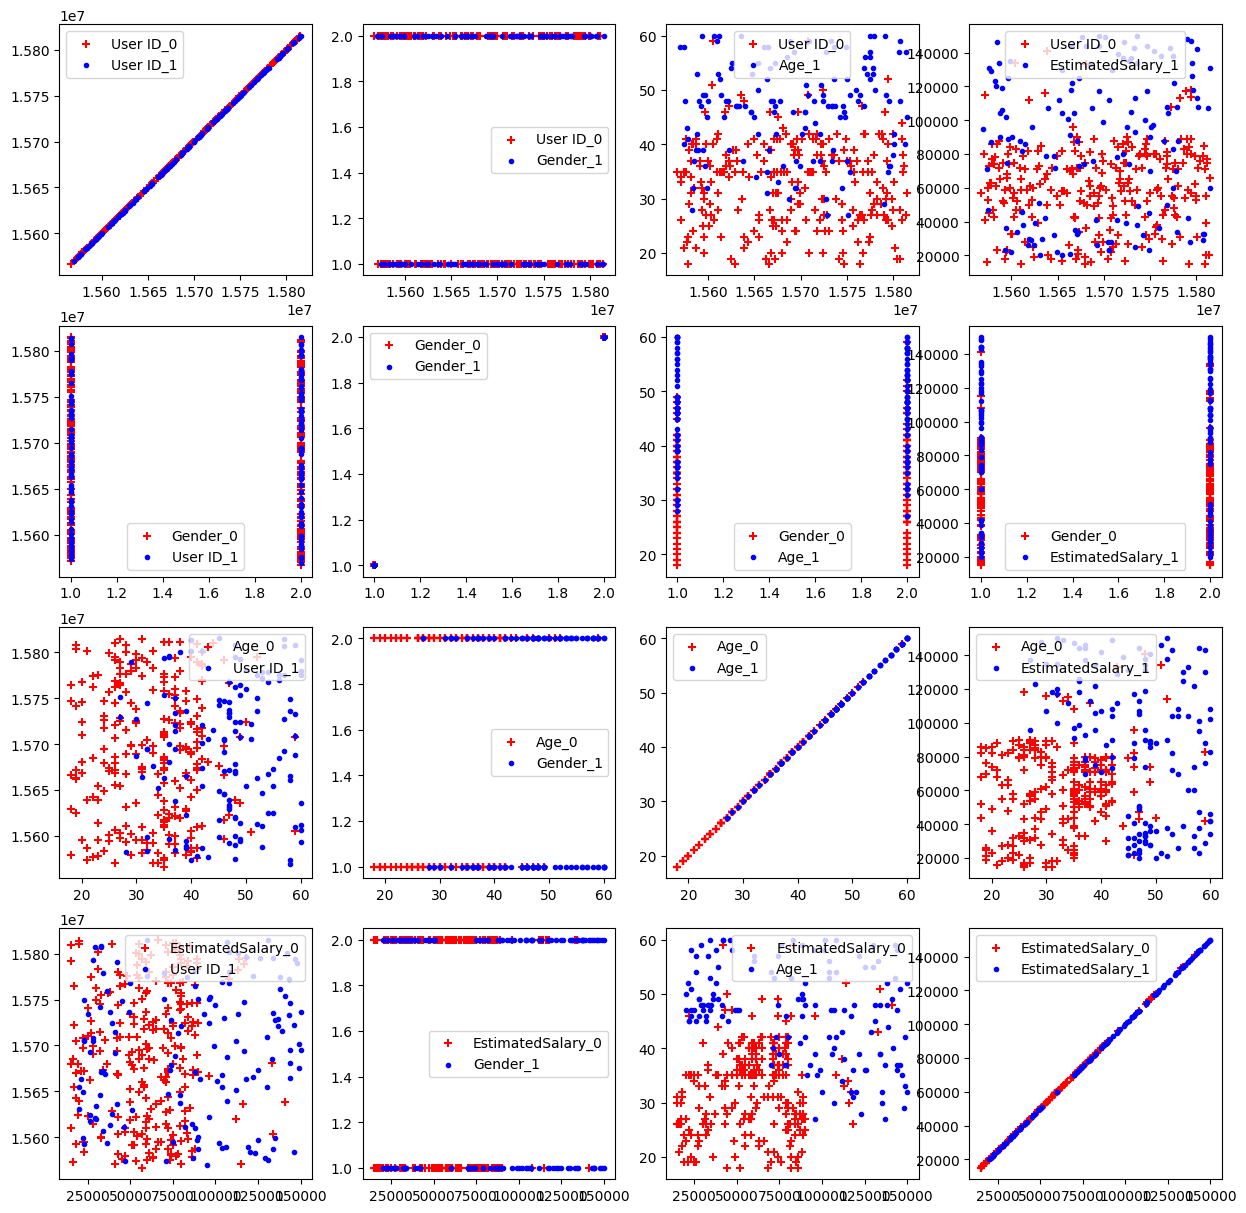

In [51]:
fig, l = plt.subplots(len(cols)-1,len(cols)-1,figsize=(15,15))

for i in range(len(cols)-1):
    for j in range(len(cols)-1):
        l[i][j].scatter(df[df["Purchased"]==0][cols[i]], df[df["Purchased"]==0][cols[j]], color='r', label = cols[i]+"_0", marker='+')
        l[i][j].scatter(df[df["Purchased"]==1][cols[i]], df[df["Purchased"]==1][cols[j]], color='b', label = cols[j]+"_1", marker = '.')
        # l[i].set_title(cols[i])
        l[i][j].legend()
fig.show()

In [45]:
x_train , x_test , y_train , y_test = train_test_split(df,df["Purchased"], test_size=0.3)

In [46]:
x_test = x_test.drop(columns="Purchased", axis=1)
x_train = x_train.drop(columns="Purchased", axis=1)

y_train = [-1 if i == 0 else 1 for i in y_train]
y_test = [-1 if i == 0 else 1 for i in y_test]

In [47]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [49]:
model = SVC()

model.fit(x_train, y_train)

SVC()

In [50]:
confusion_matrix(model.predict(x_test),y_test)

array([[90, 30],
       [ 0,  0]], dtype=int64)

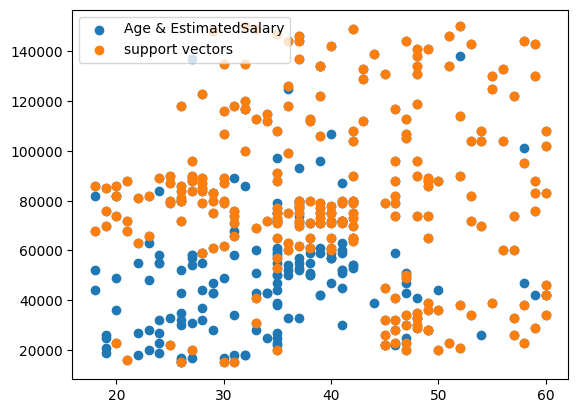

In [37]:
model.support_vectors_

plt.scatter(df[cols[2]],df[cols[3]],label = cols[2]+" & "+cols[3])
plt.scatter(model.support_vectors_[:,2],model.support_vectors_[:,3], label = "support vectors")
plt.legend()

In [38]:
kernels = ["rbf", "linear", "poly"]

for i in kernels:
    model = SVC(kernel=i,C=2)
    model.fit(x_train, y_train)
    print("Confusion matrix for ",i," : ")
    print(confusion_matrix(model.predict(x_test),y_test))

Confusion matrix for  rbf  : 
[[26 14]
 [ 0  0]]
Confusion matrix for  linear  : 
[[26 11]
 [ 0  3]]
Confusion matrix for  poly  : 
[[26 14]
 [ 0  0]]


#### News Data Multi dimensional Binary classification

In [52]:
data_set = loadmat("news.mat")
x = data_set["X_train"].todense()
print(x.shape)
ar = np.array([[j for j in i] for i in data_set["X_train"]])

(842, 15268)


In [53]:
data_set = loadmat("news.mat")
print(data_set.keys())
x = data_set["X_train"].toarray()
y = data_set["y_train"]
print(x.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X_test', 'X_train', 'y_train', 'y_test'])
(842, 15268)


In [54]:
y=y.reshape(842,)

-1

##### Using Convex Optimizer Solving for w,b

In [55]:
from cvxopt import matrix, solvers

#Initializing values and computing H. Note the 1. to force to float type
C = 10
m,n = x.shape
y = y.reshape(-1,1) * 1.
# print(y)
# X_dash = np.array([x[i]*y[0][i] for i in range(842)])*1.
X_dash = y*x
print(X_dash)
H = np.dot(X_dash , X_dash.T) * 1.

#Converting into cvxopt format - as previously
P = matrix(H)
q = matrix(-np.ones((m, 1)))
G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = matrix(y.reshape(1, -1))
b = matrix(np.zeros(1))

#Run solver
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

#==================Computing and printing parameters===============================#
w = ((y * alphas).T @ x).reshape(-1,1)
S = (alphas > 1e-4).flatten()
b = y[S] - np.dot(x[S], w)

#Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -1. -0. ... -0. -0. -0.]]
     pcost       dcost       gap    pres   dres
 0:  6.6241e+02 -2.0199e+04  4e+04  3e-01  6e-14
 1:  4.1398e+02 -4.7380e+03  7e+03  3e-02  5e-14
 2:  5.6990e+00 -1.5514e+03  2e+03  7e-03  5e-14
 3: -2.0929e+02 -5.3592e+02  4e+02  8e-04  4e-14
 4: -2.6875e+02 -3.0188e+02  3e+01  1e-05  1e-14
 5: -2.7700e+02 -2.8293e+02  6e+00  1e-06  6e-15
 6: -2.7849e+02 -2.7945e+02  1e+00  1e-07  5e-15
 7: -2.7879e+02 -2.7893e+02  1e-01  7e-09  5e-15
 8: -2.7883e+02 -2.7884e+02  1e-02  4e-10  4e-15
 9: -2.7884e+02 -2.7884e+02  4e-04  9e-12  5e-15
10: -2.7884e+02 -2.7884e+02  2e-05  1e-13  5e-15
Optimal solution found.
Alphas =  [1.00000000e+01 4.40067223e-02 3.44015644e-02 2.21493192e-02
 3.17567698e-02 3.47690550e-03 2.39179302e-02 1.39145546e-01
 1.55873214e-02 6.67950465e-02 1.37596911e-03 2.53719481e-01
 1.3

#### Testing :

In [75]:
x_test = data_set["X_test"].toarray()
y_test = data_set["y_test"]
y_test = y_test.reshape(y_test.shape[1],)

In [58]:
pred = np.array([x_test[i] @ w for i in range(561)])+np.mean(b)

In [63]:
confusion_matrix(np.array([1 if i[0]>=0 else -1 for i in pred]), y_test.reshape(561,1))

array([[200,  68],
       [110, 183]], dtype=int64)

#### Making Iterative SVM classifiier

In [27]:
class svm_custom:
    def __init__(self, learning_rate = 0.001, lmbda = 0.01, max_iter = 1000):
        self.lr = learning_rate
        self.lm = lmbda
        self.max_iter = max_iter
        self.w = None
        self.b = None

    def fit(self, x, y):
        n, d = x.shape
        y_ = np.where(y <= 0,-1,1)
        self.w = np.zeros(d)
        self.b = 0

        for _ in range(self.max_iter):
            for idx, x_i in enumerate(x):
                condition = y_[idx] * (np.dot(self.w, x_i) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2*self.lm * self.w)
                else:
                    self.w -= self.lr * (2*self.lm * self.w - x_i*y_[idx])
                    self.b -= self.lr * y_[idx]

    def predict(self, x):
        approx = x @ self.w.T - self.b
        return np.sign(approx)


In [65]:
model = svm_custom(max_iter=100)
model.fit(x, y)

In [66]:
pred = model.predict(x_test)

In [76]:
confusion_matrix(y_test, pred)

array([[195, 115],
       [ 46, 205]], dtype=int64)